In [3]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

Device: cuda


In [4]:
from torch import nn
lat_v_size = 2
img_size = 28*28

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.s = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.Flatten(start_dim=1),
            nn.Linear(3*3*32, 128),
            nn.ReLU(),
            nn.Linear(128, lat_v_size),
        )
        
    def forward(self, x):
        x = self.s(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.s = nn.Sequential(
            nn.Linear(lat_v_size, 128),
            nn.ReLU(),
            nn.Linear(128, 3*3*32),  
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=0), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.s(x)

In [5]:
test_loader = torch.utils.data.DataLoader(train_data, batch_size=2048)
def test_model(encoder, decoder, loss_fn):
    original_states = encoder.training, decoder.training
    encoder.eval(), decoder.eval()
    total_loss = torch.Tensor([0.0]).to(device)
    with torch.no_grad():
        for batch, _ in tqdm(test_loader, desc="Testing"):
            batch = batch.to(device)
            lat_v = encoder(batch)
            out = decoder(lat_v)
            total_loss += loss_fn(out, batch)
    encoder.train(original_states[0])
    decoder.train(original_states[1])
    return total_loss.item() / len(test_loader)

In [6]:
import torch.optim as optim
from tqdm import tqdm

batch_size = 64
loss_fn = torch.nn.MSELoss()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

def train_model(encoder, decoder, epochs=2):
    params = list(encoder.parameters()) + list(decoder.parameters())
    opt = optim.Adam(params, lr=1e-3)
    losses = []
    for epoch in range(epochs):
        for batch, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} "):
            batch = batch.to(device)
            lat_v = encoder(batch)
            out = decoder(lat_v)
            loss = loss_fn(out, batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.cpu().detach().numpy())
    return test_model(encoder, decoder, loss_fn), losses


In [7]:
encoder, decoder = Encoder().to(device), Decoder().to(device)
ref_loss, loss_curve = train_model(encoder, decoder, epochs=10)
print(f"ref loss: {ref_loss}")


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.14it/s]

ref loss: 0.040317062536875406


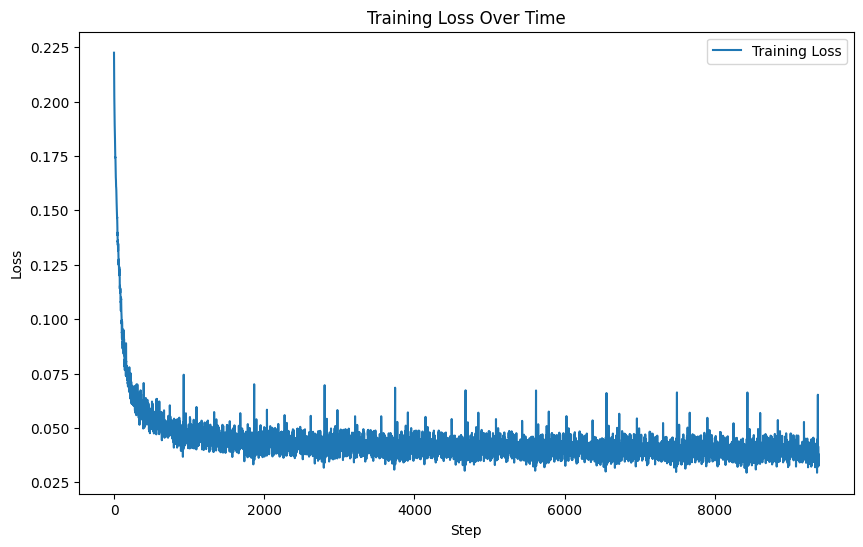

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(loss_curve)), loss_curve, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

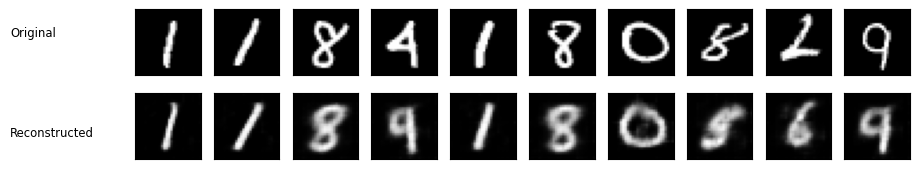

In [10]:
import matplotlib.pyplot as plt

rows, cols = 2, 10
sample_size = rows*cols
rand_ids = torch.randperm(len(test_data))[:sample_size]
rand_imgs = torch.stack([test_data[i][0] for i in rand_ids])

out = decoder(encoder(rand_imgs.to(device)))
reconstructed_images = out.cpu().detach().numpy().reshape(-1, 28, 28)

fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True, figsize=(cols, rows))
for i, ax in enumerate(axes[0]):
    ax.imshow(rand_imgs[i].squeeze(), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axes[1]):
    ax.imshow(reconstructed_images[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

fig.text(0.0, 0.75, 'Original', va='center', ha='left', rotation='horizontal', size='small')
fig.text(0.0, 0.25, 'Reconstructed', va='center', ha='left', rotation='horizontal', size='small')

plt.show()

torch.Size([10, 10, 28, 28])


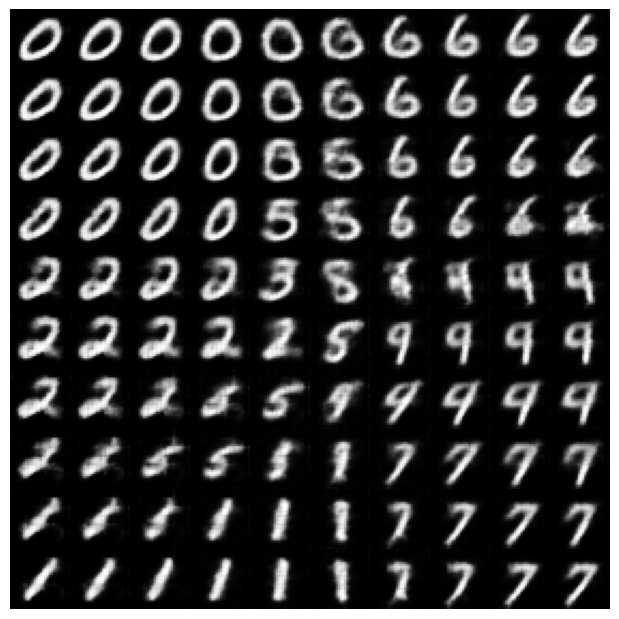

In [22]:
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = -2.0e0, 2.0e0
y_min, y_max = x_min, x_max
rows, cols = 10, 10

input = np.zeros((rows, cols, lat_v_size))
for row in range(rows):
    for col in range(cols):
        x = x_min + col * (x_max - x_min) / (cols - 1) 
        y = y_min + row * (y_max - y_min) / (rows - 1)  
        input[row][col] = np.array([x, y])
input = input.reshape(-1, 2)

out = decoder(torch.from_numpy(input).float().to(device))
out = out.reshape(rows, cols, 28, 28).cpu()
print(out.shape)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 6))
for row in range(rows):
    for col in range(cols):
        ax = axes[col, row]
        img_tensor = out[row, col]
        img = img_tensor.detach().numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
plt.show()

In [15]:
encoder

Encoder(
  (s): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=288, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [16]:
decoder

Decoder(
  (s): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (12): Sigmoid()
  )
)